# Side Project \#1: Dartmouth Academic Grading

---
The goal of this project is to scrape a Dartmouth academic webpage to get insight about grading in different classes, as well as departments.

Some of this code was borrowed from Harvard's helpful CS109 Data Science course, available [online for free](https://github.com/cs109/).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup #HTML python parsing library

In [2]:
# Get the Dartmouth page of interest
page = requests.get("http://www.dartmouth.edu/~reg/transcript/medians/16f.html")

In [3]:
s = BeautifulSoup(page.text, 'html.parser')
s.head()

[<title>Median Grades for Undergraduate Courses - Fall 2016 </title>,
 <meta content="text/html;charset=unicode-escape" http-equiv="Content-Type"/>,
 <link href="/~reg/.permacode/_permacode/common/20071201/styles/packages/screen-base.css" media="screen, print" rel="stylesheet" type="text/css"/>,
 <link href="/~reg/_permacode/current/styles/parts/custom-all.css" media="screen" rel="stylesheet" type="text/css"/>,
 <link href="/~reg/.permacode/_permacode/common/20071201/styles/packages/print.css" media="print" rel="stylesheet" type="text/css"/>,
 <link href="/~reg/_permacode/current/styles/packages/print.css" media="print" rel="stylesheet" type="text/css"/>,
 <script src="/~reg/.permacode/_permacode/common/20071201/scripts/styleswitch.js" type="text/javascript"></script>,
 <script src="/~reg/.permacode/_permacode/common/20071201/scripts/jquery.min.js" type="text/javascript"></script>,
 <script src="/~reg/.permacode/_permacode/common/20071201/scripts/rave.js" type="text/javascript"></scrip

In [4]:
# SPLIT THE DATA
rep_nl = lambda x: x.replace("\n", " ")

rows = [r for r in s.find("table").find_all("tr")]
cols = [rep_nl(col.get_text()) for col in rows[0].find_all("td") if col.get_text()]
cols

[u'TERM', u'COURSE', u'ENRL', u'MEDIAN']

In [5]:
# Aggregate all the inner values
values = [value.get_text() for row in rows[1:] for value in row.find_all("td")]
stacked_values = zip(*[values[i::4] for i in range(len(cols))])

In [6]:
# Construct a Pandas DataFrame using the Python lists
df = pd.DataFrame(stacked_values, columns = cols, index = np.arange(len(stacked_values)))
df.head()

,TERM,COURSE,ENRL,MEDIAN
0,16F,AAAS-010-01,25,A-
1,16F,AAAS-026-01,19,A
2,16F,AAAS-044-01,57,A
3,16F,AAAS-050-01,16,A-/B+
4,16F,AAAS-051-01,13,A


In [7]:
# For now we don't care about the `TERM` variable, which is constant in the chart
grades = df.drop('TERM', axis=1)
grades.head()

,COURSE,ENRL,MEDIAN
0,AAAS-010-01,25,A-
1,AAAS-026-01,19,A
2,AAAS-044-01,57,A
3,AAAS-050-01,16,A-/B+
4,AAAS-051-01,13,A


If we look at the types contained in the table, we see that they are all considered `objects`. To conduct analysis, let's make `ENRL` an integer and map the `MEDIAN` GPA grades to a float.

In [8]:
GRADE_NUM = {"A":4.0, "A /A-": 3.85, "A-":3.7, "A-/B+":3.5, "B+":3.3,
            "B+/B":3.15, "B":3.0, "B /B-":2.85, "B-":2.7}
numeric = lambda x: x if x not in GRADE_NUM else GRADE_NUM[x]
grades.ENRL = [int(enrl) for enrl in grades['ENRL']]
grades.MEDIAN = [numeric(grade) for grade in grades['MEDIAN']]
grades.dtypes

COURSE     object
ENRL        int64
MEDIAN    float64
dtype: object

That looks good. Now that it's cleaned up, let's inspect this table.

In [9]:
grades.head()

,COURSE,ENRL,MEDIAN
0,AAAS-010-01,25,3.7
1,AAAS-026-01,19,4.0
2,AAAS-044-01,57,4.0
3,AAAS-050-01,16,3.5
4,AAAS-051-01,13,4.0


In [10]:
grades.describe()

,ENRL,MEDIAN
count,491.000000,491.000000
mean,34.073320,3.584012
std,31.928407,0.308955
min,10.000000,2.700000
25%,15.000000,3.300000
50%,22.000000,3.700000
75%,42.000000,3.700000
max,203.000000,4.000000


Let's do some exploratory analysis between enrollment and median grade.

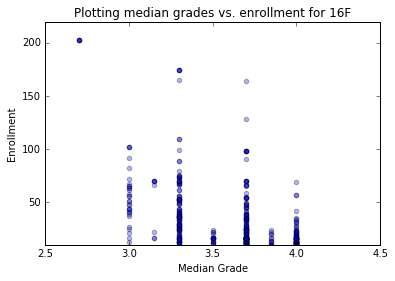

In [11]:
plt.scatter(grades.MEDIAN, grades.ENRL, alpha=0.3)
plt.xlim(2.5,4.5)
plt.ylim(10,220)
plt.title("Plotting median grades vs. enrollment for 16F")
plt.xlabel("Median Grade")
plt.ylabel("Enrollment")

It looks like the larger the class, the higher the probability of a lower median grade in the class. However, we are only accounting for a single term. Let's see if we can abstract our methodology above to examine other semesters.

## Abstraction
---
Let's see if we can perform this type of analysis for any term available online. Current terms available are 14X to 16F.

In [12]:
def get_table(term):
    """
    PARAMETERS
    ----------
    term : String
        Specifies the academic quarter at Dartmouth to analyze publically accesible grade
        information (i.e., ["14X", "14F", "15W", "15S", "15X", "15F", "16W", "16S", "16W",
        "16F"])
        
    RETURNS
    -------
    Pandas DataFrame:
        Contains COURSE (Courses), ENRL (Enrollment), and MEDIAN (median grade in course) for
        specified term
        
    REQUIREMENTS
    ------------
    Pandas, Requests, BeautifulSoup
    """
    # Definitions:
    GRADE_NUM = {"A":4.0, "A /A-": 3.85, "A-":3.7, "A-/B+":3.5, "B+":3.3,
            "B+/B":3.15, "B":3.0, "B /B-":2.85, "B-":2.7, "B-/C+":2.5, "C+":2.3,
            "C+/C":2.15, "C":2.0, "C /C-":1.85, "C-":1.7, "C-/D+":1.5, "D+":1.3,
            "D+/D":1.15, "D":1.0, "E":0.0}
    
    # Lambda expressions:
    rep_nl = lambda x: x.replace("\n", " ")
    numeric = lambda x: x if x not in GRADE_NUM else GRADE_NUM[x]
    
    # First set up BeautifulSoup to help parse the HTML content
    url = "http://www.dartmouth.edu/~reg/transcript/medians/" + term + ".html"
    page = requests.get(url)
    
    if not page.ok:
        print "ERROR: Please choose a valid term"
        return None
    
    s = BeautifulSoup(page.text, 'html.parser')
    
    # Extract Rows, Columns, and Values
    rows = [r for r in s.find("table").find_all("tr")]
    cols = [rep_nl(col.get_text()) for col in rows[0].find_all("td") if col.get_text()]
    values = [value.get_text() for row in rows[1:] for value in row.find_all("td")]
    stacked_values = zip(*[values[i::4] for i in range(len(cols))])
    
    # Create the DataFrame
    df = pd.DataFrame(stacked_values, columns = cols, index = np.arange(len(stacked_values)))
    
    # Clean up the DataFrame
    grades = df.drop('TERM', axis=1)
    grades.ENRL = [int(enrl) for enrl in grades['ENRL']]
    grades.MEDIAN = [numeric(grade) for grade in grades['MEDIAN']]
    
    return grades

# Example:
term = "15S"
grades = get_table(term)
grades.head()

,COURSE,ENRL,MEDIAN
0,AAAS-012-01,11,3.3
1,AAAS-014-01,17,3.3
2,AAAS-015-01,18,3.5
3,AAAS-023-01,30,3.3
4,AAAS-025-01,12,3.3


### Adding Complexity
---
Next let's see if we can group the `COURSE` column by department and analyze the grades and enrollment by generalizing to the entire `DEPT`.

In [13]:
dept_df = grades['COURSE'].str[:4].to_frame()
dept_df.columns = ['DEPT']
res = pd.concat([dept_df, grades], axis=1).groupby(['DEPT'])
res.agg([np.sum, np.mean, np.std]).head()

ENRL                       MEDIAN                    
      sum       mean        std    sum      mean       std
DEPT                                                      
AAAS  179  17.900000   6.573516  35.95  3.595000  0.292926
AMES  309  23.769231  14.024703  48.35  3.719231  0.286893
ANTH  291  22.384615   9.535359  47.55  3.657692  0.305400
ARAB   31  15.500000   0.707107   7.70  3.850000  0.212132
ARTH  206  20.600000  12.339638  35.90  3.590000  0.233095

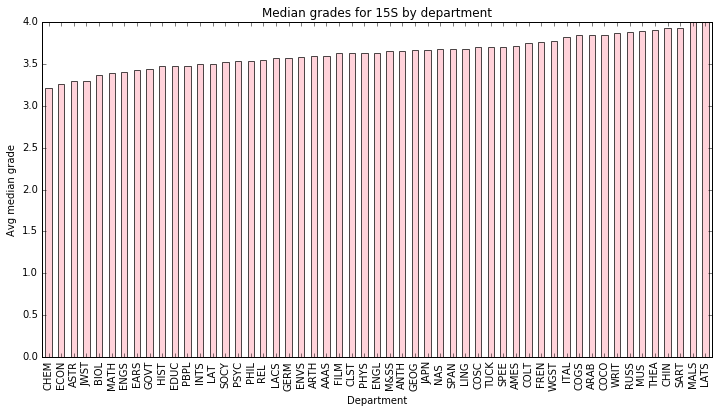

In [14]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
mean_med = res.mean()['MEDIAN'].sort_values()
mean_med.plot(kind='bar', alpha = 0.7, color='pink')
plt.title("Median grades for %s by department" % term)
plt.xlabel("Department")
plt.ylabel("Avg median grade")
plt.show()

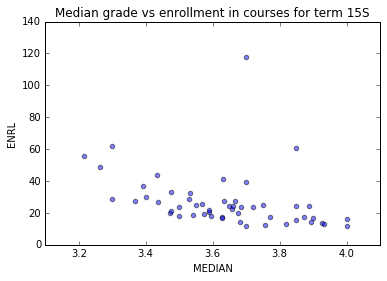

In [15]:
res_df = res.mean()
res_df.plot(kind='scatter', x='MEDIAN', y='ENRL', alpha=0.5,
           title='Median grade vs enrollment in courses for term %s' % term)

We can make a function that produces the `DEPT` column in the dataframe. If you notice, the first four letters in the `COURSE` description correspond with the department the class belongs to. We can use this fact to assign departments to each class in our list.

In [16]:
def get_dept(table):
    """
    PARAMETERS
    ----------
    table: DataFrame
        Contains the 'COURSE', 'ENRL', and 'MEDIAN' info for any academic term
    
    RETURNS
    -------
    DataFrame with 'DEPT' information that align with the 'COURSE' info from the initial table
    
    """
    depts = table['COURSE'].str[:4].to_frame()
    depts.columns = ['DEPT']
    return depts

# Example:
term = "15W"
table = get_table(term)
depts = get_dept(table)
depts.head()

,DEPT
0,AAAS
1,AAAS
2,AAAS
3,AAAS
4,AAAS


## Acquiring More Data
---

Let's combine all the course data we can find available on the site we first queried.

In [17]:
listed_terms = ["14X", "14F", "15W", "15S", "15X", "15F", "16W", "16S", "16W", "16F"]
comb_df = get_table(listed_terms[0])
depts = get_dept(comb_df)
comb_df = pd.concat([depts, comb_df], axis=1)

for term in listed_terms[1:]:
    df = get_table(term)
    df = pd.concat([get_dept(df), df], axis=1)
    comb_df = pd.concat([comb_df, df])

print "We now have information about %i classes over %i terms" % (len(comb_df.index), len(listed_terms))

We now have information about 4230 classes over 10 terms


In [18]:
# Group the DataFrame by Departments, then see the average data for each department
dept_groups = comb_df.groupby(['DEPT'])
res = dept_groups.mean()
res.head()

,ENRL,MEDIAN
DEPT,,
AAAS,19.735294,3.605147
AMEL,16.000000,3.700000
AMES,25.811594,3.709420
ANTH,26.769231,3.665385
ARAB,16.285714,3.925000


### Department Comparison

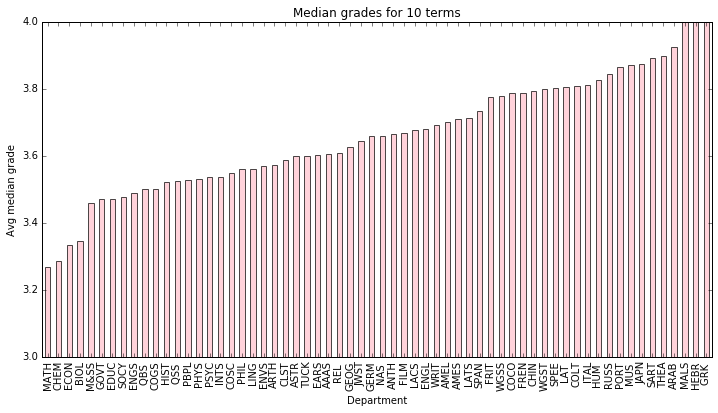

In [19]:
# Plot the avg median grades for each department
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

mean_med = res['MEDIAN'].sort_values()
mean_med.plot(kind='bar', alpha = 0.7, color='pink')
plt.title("Median grades for %i terms" % len(listed_terms))
plt.xlabel("Department")
plt.ylabel("Avg median grade")
plt.ylim(3.0, 4.0)
plt.show()

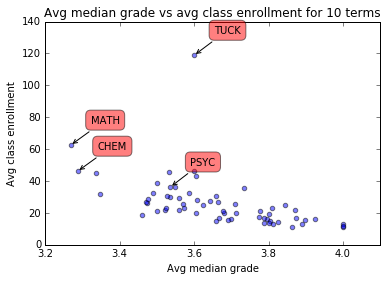

In [20]:
# Analyze the avg median grade vs dept enrollment
dept_annotations = ['MATH', 'CHEM', 'PSYC', 'TUCK']

plt.scatter(res['MEDIAN'], res['ENRL'], alpha=0.5)
plt.title('Avg median grade vs avg class enrollment for %i terms' % len(listed_terms))
plt.xlabel('Avg median grade')
plt.ylabel('Avg class enrollment')
for d in dept_annotations:
    plt.annotate(d, xy = (res.loc[d]['MEDIAN'], res.loc[d]['ENRL']),
                xytext = (20,20), textcoords='offset points', ha='left', va='bottom',
                bbox = dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
                arrowprops = dict(arrowstyle='->', facecolor='black', connectionstyle='arc3,rad=0'))
plt.show()

## Independent Department Analysis
---
Currently we have amassed data generalized to the department level. Let's try to use our information from all the terms we combined to get trends in individual departments based on medians and class sizes.

In [21]:
course_group = comb_df.groupby(['DEPT', 'COURSE'])
grouped_df = course_group.agg(np.mean)
grouped_df.head()

ENRL  MEDIAN
DEPT COURSE                        
AAAS AAAS-010-01  19.333333     3.7
     AAAS-011-01  12.000000     3.3
     AAAS-012-01  12.500000     3.3
     AAAS-013-01  16.666667     3.0
     AAAS-014-01  17.500000     3.3

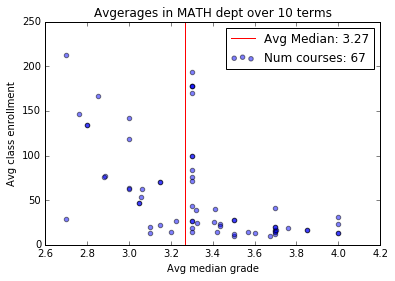

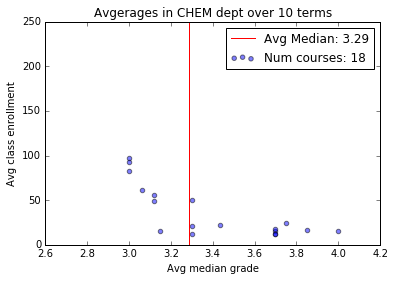

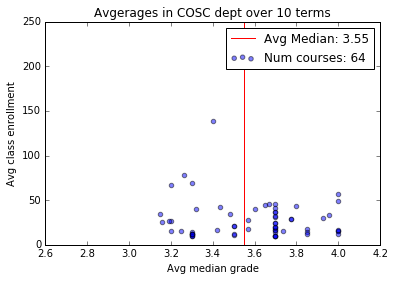

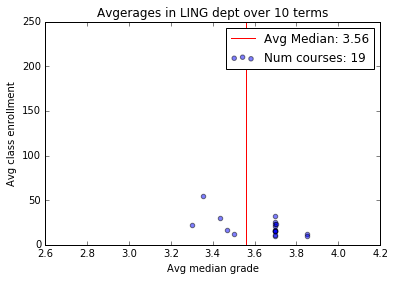

In [22]:
# Plotting avg median grade vs avg class enrollment by class for specified departments
courses = ['MATH', 'CHEM', 'COSC', 'LING']

for course in courses:
    plt.scatter(grouped_df.loc[course]['MEDIAN'], grouped_df.loc[course]['ENRL'], alpha=0.5,
               label='Num courses: %i' % len(grouped_df.loc[course]['MEDIAN']))
    plt.title('Avgerages in %s dept over %i terms' % (course, len(listed_terms)))
    plt.xlabel('Avg median grade')
    plt.ylabel('Avg class enrollment')
    plt.xlim(2.6, 4.2)
    plt.ylim(0, 250)
    plt.axvline(res.loc[course]['MEDIAN'], 0, 250, color='r', label='Avg Median: %.2f' %
               res.loc[course]['MEDIAN'])
    plt.legend(numpoints=1)
    plt.show()

## Back to Class
---

This still gives a broad overview of the departments. Let's see if we can sniff out the number of the course in each department, then make a histogram of median class grade based on course number. Recall how we extracted the department from the course title? We can use the same reasoning to get the course number.

Notice that while we examine grades given a course, we are acting as if each was independent. This is not true, since there may be many sections of the same course which we're counting separately. This allows us to simplify the analysis. However, we should keep this bias in mind.

In [23]:
comb_df.head()

,DEPT,COURSE,ENRL,MEDIAN
0,AAAS,AAAS-014-01,18,3.3
1,AAAS,AAAS-046-01,13,3.3
2,AAAS,AAAS-81.04-01,11,4.0
3,AMES,AMES-008-01,32,3.7
4,ANTH,ANTH-003-01,48,4.0


The title for the courses contain the department, the course number, and the section. Therefore we will have to clean up the data in order to only account for the course number. For now we will disregard the section numbers, naively assuming each section is the same.

In [24]:
import re # used for multiple delimiter splits

def get_course_nums(table):
    """
    PARAMETERS
    ----------
    table: DataFrame
        Contains the `COURSE`, `ENRL`, and `MEDIAN` information for any academic term
    
    RETURNS
    -------
    Dataframe containing course numbers aligned with their corresponding course titles from
    the initial DataFrame `df`
    
    """
    nums_dirty = table['COURSE'].str[5:].to_frame()
    nums_list = [re.split('[- .]',str(nums_dirty.iloc[i]['COURSE']))[0] 
                 for i in range(len(nums_dirty.index))]
    nums_df = pd.DataFrame(nums_list, columns=['NUM'])
    nums_df.NUM = [int(num) for num in nums_df.NUM]
    return nums_df

#Example:
term = "15X"
grades = get_table(term)
course_nums = get_course_nums(grades)
course_nums.head()

,NUM
0,88
1,40
2,40
3,3
4,55


That looks good! Now we can reformat our dataframe to include the following columns -- `DEPT`, `NUM`, `ENRL`, and `MEDIAN`. After, we can group course numbers and departments together and perform analysis by department.

Currently, we have several functions:

- `get_table(term)`
- `get_dept(table)`
- `get_course_nums(table)`

Let's make a function called `get_clean_df` that uses each of these functions, having parsed through the dirty `COURSE` titles to extract `DEPT` (department) and `NUM` (course number). This function should return a cleaned up DataFrame, as documented:

In [25]:
def get_clean_df(term):
    """
    PARAMETERS
    ----------
    term: String
        Specifies the academic term to retrieve data for
    
    RETURNS
    -------
    DataFrame containing `DEPT`, `NUM`, `ENRL`, and `MEDIAN`; that is, the DataFrame contains
    information about the department, class number, enrolled students, and median grade for
    each class during the specified `term`
    
    """
    table = get_table(term)
    depts = get_dept(table)
    course_nums = get_course_nums(table)
    df = table.drop('COURSE', axis=1)
    df = pd.concat([depts, course_nums, df], axis=1)
    return df

# Example:
df = get_clean_df("15X")
df.head()

,DEPT,NUM,ENRL,MEDIAN
0,AAAS,88,30,3.3
1,AMES,40,10,3.5
2,AMES,40,54,3.7
3,ANTH,3,50,3.3
4,ANTH,55,27,3.3


In [26]:
# Get a clean DataFrame containing information from every listed term online
listed_terms = ["14X", "14F", "15W", "15S", "15X", "15F", "16W", "16S", "16X", "16F"]

# Initialize our DataFrame containing every class across our `listed_terms`
full_df = get_clean_df(listed_terms[0])

# Keep track of each term separately as well
list_dfs = [full_df]

for term in listed_terms[1:]:
    df = get_clean_df(term)
    full_df = pd.concat([full_df, df])
    list_dfs.append(df)

full_df.head()

,DEPT,NUM,ENRL,MEDIAN
0,AAAS,14,18,3.3
1,AAAS,46,13,3.3
2,AAAS,81,11,4.0
3,AMES,8,32,3.7
4,ANTH,3,48,4.0


In [27]:
# Clean the data
full_group = full_df.groupby(['DEPT', 'NUM'])
full_group_df = full_group.agg(np.mean)
full_group_df.head()

ENRL  MEDIAN
DEPT NUM                   
AAAS 7    15.500000     3.7
     10   19.333333     3.7
     11   12.000000     3.3
     12   12.500000     3.3
     13   15.500000     3.0

### Department Analysis by Classes
---

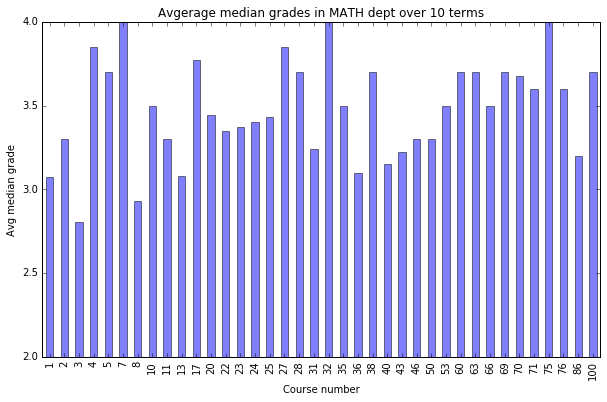

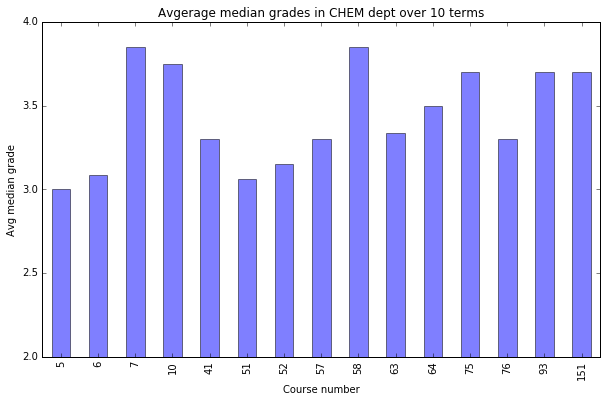

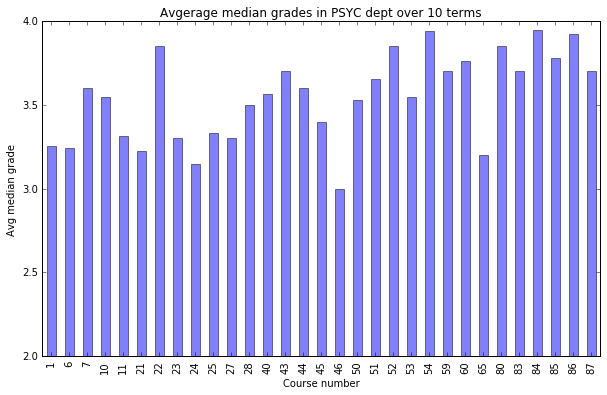

In [28]:
# Analyze the average median grades for specified departments by classes
courses = ['MATH', 'CHEM', 'PSYC']

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

for course in courses:
    full_group_df.loc[course]['MEDIAN'].plot(kind='bar', alpha=0.5)
    plt.title('Avgerage median grades in %s dept over %i terms' % (course, len(listed_terms)))
    plt.xlabel('Course number')
    plt.ylabel('Avg median grade')
    plt.ylim(2.0, 4.0)
    plt.show()
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

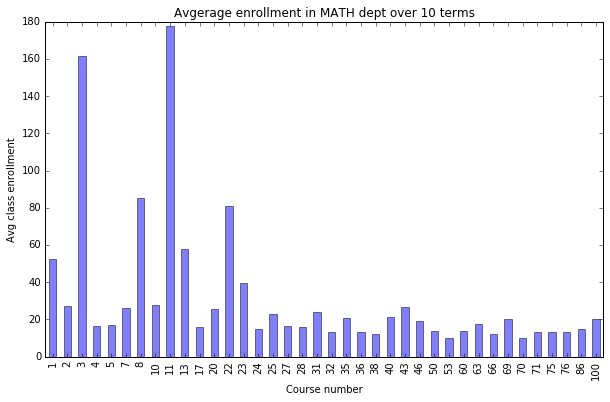

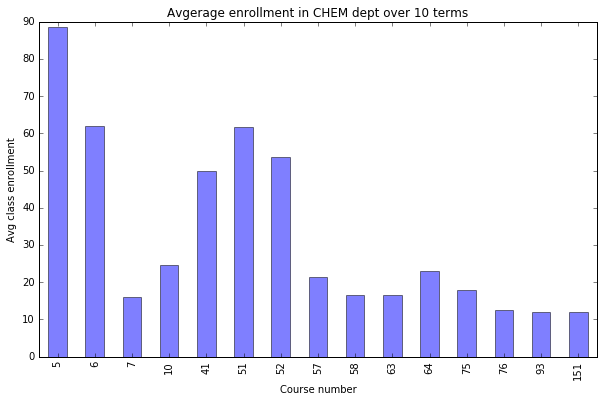

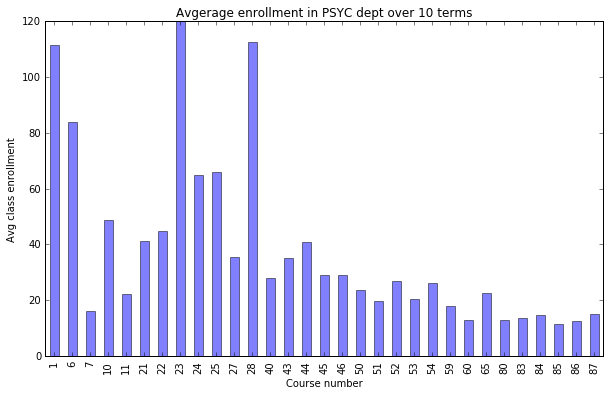

In [29]:
# Analyze average enrollments by class for specified departments
courses = ['MATH', 'CHEM', 'PSYC']

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

for course in courses:
    full_group_df.loc[course]['ENRL'].plot(kind='bar', alpha=0.5)
    plt.title('Avgerage enrollment in %s dept over %i terms' % (course, len(listed_terms)))
    plt.xlabel('Course number')
    plt.ylabel('Avg class enrollment')
    plt.show()
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

### Interpretations

By analyzing the graphs for average course enrollment by department, we can tell which classes are more popular than others. For example, when we search for the `MATH` department, we can tell that classes such as Math 3 and Math 11 have exceptionally large enrollment when they are offered.

Similarly, we can see which courses tend to be easier than others by analyzing the average median grades for courses by department.

### Trends and Patterns in Dept Medians and Dept Enrollment by Term
---

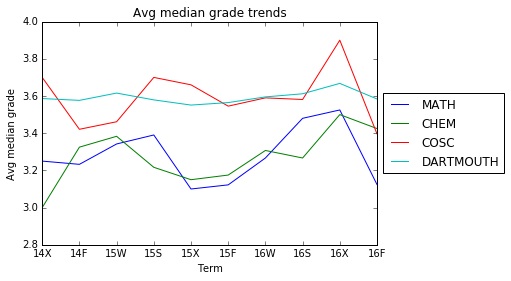

In [31]:
# Analyzing median grade patterns across terms by department
med_means = [list_dfs[i].groupby(['DEPT']).mean().MEDIAN.to_frame() for i in range(len(list_dfs))]
med_dfs = pd.concat(med_means, axis=1)
med_dfs.columns = listed_terms
med_dfs = med_dfs.fillna(0.0).astype(float)

courses = ['MATH', 'CHEM', 'COSC']

for course in courses:
    med_dfs.loc[course].plot(kind='line', label='%s' % course)

# Show a plot of the average median grade for the school over `listed_terms`
school_means = [list_dfs[i].mean().MEDIAN for i in range(len(list_dfs))]
plt.plot(school_means, label='DARTMOUTH')

plt.xlabel('Term')
plt.ylabel('Avg median grade')
plt.title('Avg median grade trends')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

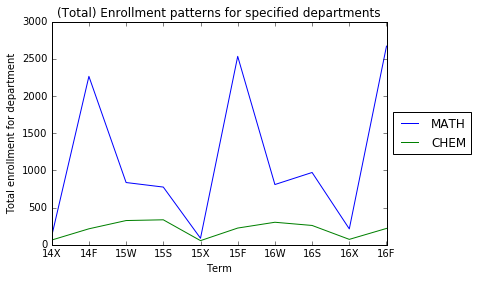

In [32]:
# Analyzing enrollment patterns across terms by department
enrl_totals = [list_dfs[i].groupby(['DEPT']).sum().ENRL.to_frame() for i in range(len(list_dfs))]
enrl_dfs = pd.concat(enrl_totals, axis=1)
enrl_dfs.columns = listed_terms
enrl_dfs = enrl_dfs.fillna(0).astype(int)

courses = ['MATH', 'CHEM']

for course in courses:
    enrl_dfs.loc[course].plot(kind='line', label='%s' % course)
    plt.xlabel('Term')
    plt.ylabel('Total enrollment for department')
    plt.title('(Total) Enrollment patterns for specified departments')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))